In [1]:
# Autoreload packages that are modified
%load_ext autoreload
%autoreload 2

import collections
from datetime import datetime, timedelta
import glob
import os
import sys
import time
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from data import get_data
from utils import plot_forecast, plot_components

cwd = os.getcwd()
sys.path.append(f"{cwd}/forecast_rodeo")
sys.path.append(f"{cwd}/forecast_rodeo/src/experiments")

In [2]:
# https://stackoverflow.com/questions/43147983/could-not-create-cudnn-handle-cudnn-status-internal-error
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Get the data

In [3]:
num_forecast_steps = 7 * 4 # 28 days

X, anoms, clims, temps, dates, \
columnstr_to_index, index_to_columnstr = get_data()

# X = X.astype(np.float16)
# anoms = anoms.astype(np.float16)
# clims = clims.astype(np.float16)
# temps = temps.astype(np.float16)

num_data_to_consider = 365 * 10 # 10 years worth of data
assert(num_data_to_consider > num_forecast_steps)

X_train = X[-num_data_to_consider:-num_forecast_steps, :]
anoms_train = anoms[-num_data_to_consider:-num_forecast_steps]
clims_train = clims[-num_data_to_consider:-num_forecast_steps]
temps_train = temps[-num_data_to_consider:-num_forecast_steps]
dates_train = dates[-num_data_to_consider:-num_forecast_steps]

X_test = X[-num_forecast_steps:, :]
anoms_test = anoms[-num_forecast_steps:]
clims_test = clims[-num_forecast_steps:]
temps_test = temps[-num_forecast_steps:]
dates_test = dates[-num_forecast_steps:]

is_predicting_anomaly = False
if is_predicting_anomaly:
    Y_train = anoms_train
    Y_test = anoms_test
    print(f"Y is temperature anomaly!")
else:
    Y_train = temps_train
    Y_test = temps_test
    print(f"Y is temperature directly!")


['forecast_rodeo/results/regression/shared/contest_tmp2m_34w/lat_lon_date_data-contest_tmp2m_34w.h5', 'forecast_rodeo/results/regression/shared/contest_tmp2m_34w/date_data-contest_tmp2m_34w.h5']
lat_oi: 27.0, lon_oi: 261.0
Y is temperature directly!


In [4]:
print(clims.shape)

(13283,)


In [5]:
years_in_data = dates.dt.year
first_year = min(years_in_data)
last_year = max(years_in_data)
print(first_year)
print(last_year)

print(index_to_columnstr)

num_forecast_steps = 7 * 4 # 28 days

1982
2018
{0: 'tmp2m_shift29', 1: 'tmp2m_shift29_anom', 2: 'tmp2m_shift58', 3: 'tmp2m_shift58_anom', 4: 'rhum_shift30', 5: 'pres_shift30', 6: 'nmme_wo_ccsm3_nasa', 7: 'nmme0_wo_ccsm3_nasa', 8: 'mei_shift45', 9: 'phase_shift17', 10: 'sst_2010_1_shift30', 11: 'sst_2010_2_shift30', 12: 'sst_2010_3_shift30', 13: 'icec_2010_1_shift30', 14: 'icec_2010_2_shift30', 15: 'icec_2010_3_shift30', 16: 'wind_hgt_10_2010_1_shift30', 17: 'wind_hgt_10_2010_2_shift30'}


(3622,)


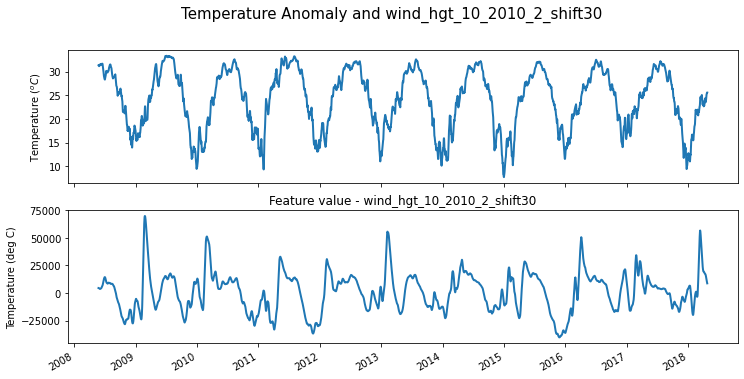

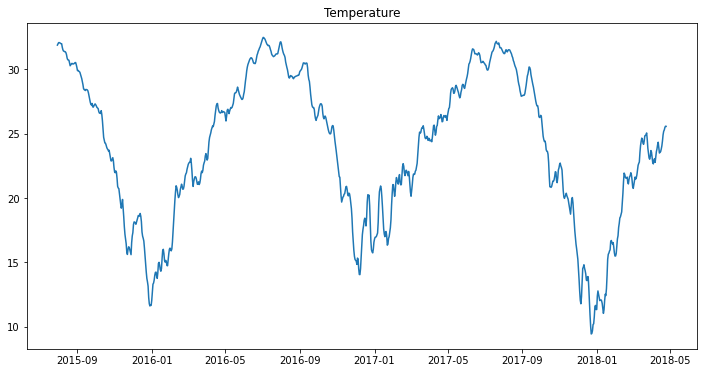

In [6]:
print(Y_train.shape)

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(dates_train,
        Y_train, lw=2, label="training data")
ax.set_ylabel("Temperature ($^oC$)")

ax = fig.add_subplot(2, 1, 2)

feature_str = "wind_hgt_10_2010_2_shift30"
ax.plot(dates_train,
        X_train[:, columnstr_to_index[feature_str]], lw=2, label="training data")
ax.set_ylabel("Temperature Anomaly (deg C)" if is_predicting_anomaly else "Temperature (deg C)")
ax.set_title(f"Feature value - {feature_str}")
fig.suptitle(f"Temperature Anomaly and {feature_str}" if is_predicting_anomaly else 
             f"Temperature Anomaly and {feature_str}",
             fontsize=15)
fig.autofmt_xdate()

plt.figure(figsize=(12, 6))
plt.title(f"Temperature Anomaly" if is_predicting_anomaly else f"Temperature")
plt.plot(dates_train[-1000:], Y_train[-1000:])


In [1]:
def build_model(observed_time_series):
#     weekly = tfp.sts.Seasonal(
#         num_seasons=52, 
#         observed_time_series=observed_time_series,
#         num_steps_per_season=7, 
#         name='weekly'
#     )
    weekly = tfp.sts.SmoothSeasonal(
        period=7,
        frequency_multipliers=[1, 2, 3],
        initial_state_prior=tfd.MultivariateNormalDiag(scale_diag=tf.ones([6])),
        observed_time_series=observed_time_series,
        name='weekly'
    )

#     seasonal = tfp.sts.Seasonal(
#         num_seasons=4, 
#         observed_time_series=observed_time_series,
#         num_steps_per_season=91, 
#         name='seasonal'
#     )
#     monthly = tfp.sts.Seasonal(
#         num_seasons=12,
#         observed_time_series=observed_time_series,
#         num_steps_per_season=[31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
#         drift_scale_prior=tfd.LogNormal(loc=-1., scale=0.1),
#         initial_effect_prior=tfd.Normal(loc=0., scale=5.),
#         name='month_of_year',
#     )
#     features_effect = tfp.sts.DynamicLinearRegression(
#     features_effect = tfp.sts.LinearRegression(
#         design_matrix=X, #- np.mean(X), 
#         design_matrix=X_train, #- np.mean(X_train), 
#         name='other_features'
#     )   
#     autoregressive = tfp.sts.Autoregressive(
#         order=1,
#         observed_time_series=observed_time_series,
#         name='autoregressive'
#     )
#     semilocal = tfp.sts.SemiLocalLinearTrend()
    model = tfp.sts.Sum([
        weekly,
#         seasonal,
#         monthly,
#         features_effect,
#         autoregressive
#         semilocal

        ],
        observed_time_series=observed_time_series
    )
    return model

temperature_model = build_model(Y_train)

variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=temperature_model)
print(variational_posteriors)

NameError: name 'Y_train' is not defined

75
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Do not call `graph_parents`.
133.280020236969 seconds


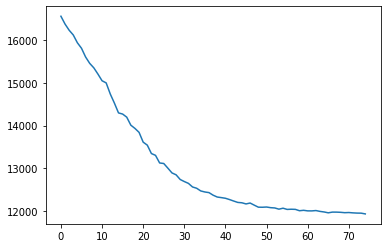

In [8]:
# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 75
print(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)

# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
  elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=temperature_model.joint_log_prob(
        observed_time_series=Y_train),
    surrogate_posterior=variational_posteriors,
    optimizer=optimizer,
    num_steps=num_variational_steps)
  return elbo_loss_curve

start = time.time()
elbo_loss_curve = train()
end = time.time()
print(f"{end - start} seconds")
plt.plot(elbo_loss_curve)
plt.show()

In [16]:
print(elbo_loss_curve)

tf.Tensor(
[16552.705  16370.632  16226.44   16115.922  15934.001  15805.942
 15601.771  15453.184  15348.4795 15203.123  15047.404  14997.416
 14738.172  14526.399  14296.989  14270.45   14198.104  14010.82
 13934.965  13843.159  13614.742  13544.954  13348.938  13306.665
 13128.879  13116.768  13008.386  12896.79   12852.734  12743.455
 12695.51   12653.014  12568.967  12538.893  12476.301  12452.02
 12437.203  12377.511  12334.481  12320.59   12305.255  12274.838
 12240.761  12208.386  12200.05   12173.184  12194.085  12144.9
 12097.545  12095.762  12101.019  12085.9375 12079.364  12051.029
 12073.438  12045.272  12049.477  12046.365  12014.49   12024.409
 12011.045  12010.7    12018.64   11998.935  11985.509  11965.831
 11982.313  11981.908  11977.534  11968.917  11972.7    11964.614
 11959.46   11957.765  11940.188 ], shape=(75,), dtype=float32)


In [10]:
# Draw samples from the variational posterior.
q_samples_temperature_ = variational_posteriors.sample(25)


print("Inferred parameters:")
for param in temperature_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_temperature_[param.name], axis=0),
                              np.std(q_samples_temperature_[param.name], axis=0)))


Inferred parameters:
observation_noise_scale: 6.549839496612549 +- 0.08314154297113419
weekly/_drift_scale: 0.11648708581924438 +- 0.006104503758251667


## Forecasting

In [11]:
start = time.time()
temperature_forecast_dist = tfp.sts.forecast(
    model=temperature_model,
    observed_time_series=Y_train[-10 * 365:],
    parameter_samples=q_samples_temperature_,
    num_steps_forecast=num_forecast_steps)
end = time.time()
print(f"time elapsed = {end - start}")

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
time elapsed = 66.06754541397095


skill: -0.9987910985946655


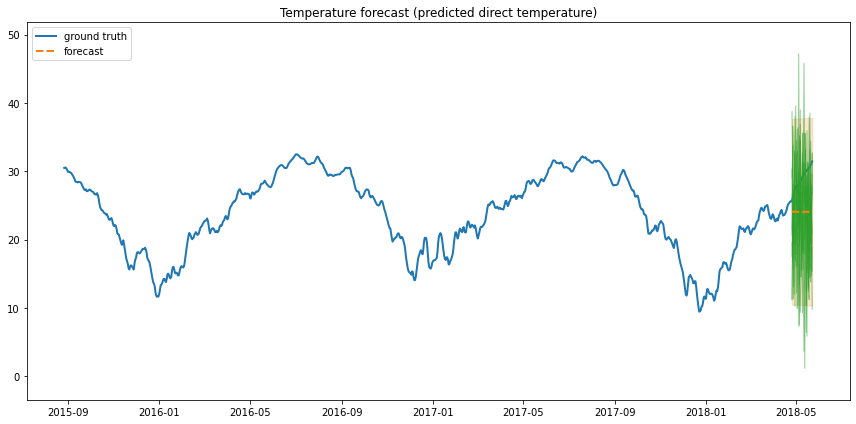

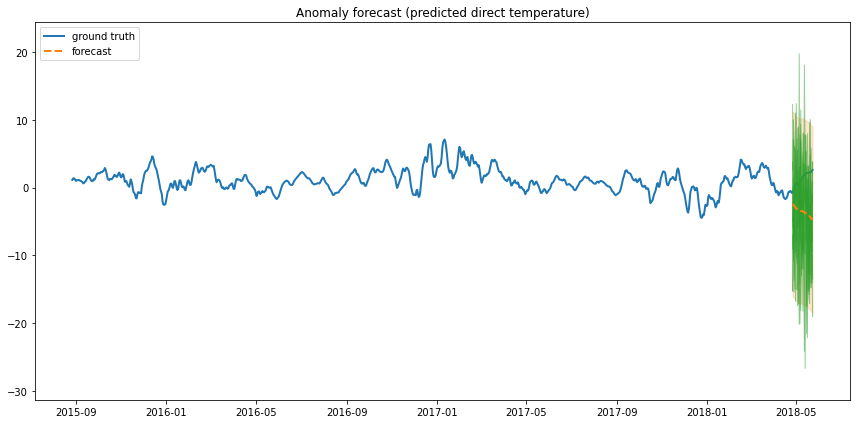

In [17]:
num_samples=10
plot_num = 1000

(
    temperature_forecast_mean,
    temperature_forecast_scale,
    temperature_forecast_samples
) = (
    temperature_forecast_dist.mean().numpy()[..., 0],
    temperature_forecast_dist.stddev().numpy()[..., 0],
    temperature_forecast_dist.sample(num_samples).numpy()[..., 0]
    )

if is_predicting_anomaly:
    fig, ax = plot_forecast(dates, anoms + clims,
                            temperature_forecast_mean + clims_test,
                            temperature_forecast_scale,
                            temperature_forecast_samples + clims_test,
                            title="Temperature forecast (predicted anomaly)",
                            plot_num=plot_num,
    )
    fig.tight_layout()
    fig, ax = plot_forecast(dates, anoms,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Anomaly forecast (predicted anomaly)",
                            plot_num=plot_num,
    )
    fig.tight_layout()

    
    anoms_hat = temperature_forecast_mean[14:]
    print(anoms_hat)
    anoms_hat_norm = anoms_hat / np.linalg.norm(anoms_hat)
    anoms_test_norm = anoms_test[14:] / np.linalg.norm(anoms_test[14:])
    print(f"skill: {anoms_hat_norm.dot(anoms_test_norm)}")

    
else:
    fig, ax = plot_forecast(dates, temps,
                            temperature_forecast_mean,
                            temperature_forecast_scale,
                            temperature_forecast_samples,
                            title="Temperature forecast (predicted direct temperature)",
                            plot_num=plot_num,
    )
    fig.tight_layout()

    fig, ax = plot_forecast(dates, anoms,
                        temperature_forecast_mean - clims_test,
                        temperature_forecast_scale,
                        temperature_forecast_samples - clims_test,
                        title="Anomaly forecast (predicted direct temperature)",
                        plot_num=plot_num,
    )
    fig.tight_layout()
    
    
    anoms_hat = temperature_forecast_mean[14:] - clims_test[14:]
    anoms_hat_norm = anoms_hat / np.linalg.norm(anoms_hat)
    anoms_test_norm = anoms_test[14:] / np.linalg.norm(anoms_test[14:])
    print(f"skill: {anoms_hat_norm.dot(anoms_test_norm)}")


In [18]:
num_to_plot_for_decomp = 10 * 365
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = tfp.sts.decompose_by_component(
    temperature_model,
    observed_time_series=Y_train[-num_to_plot_for_decomp:],
    parameter_samples=q_samples_temperature_
)

forecast_component_dists = tfp.sts.decompose_forecast_by_component(
    temperature_model,
    forecast_dist=temperature_forecast_dist,
    parameter_samples=q_samples_temperature_
)


temperature_component_means_, temperature_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

temperature_forecast_component_means_, temperature_forecast_component_stddevs_ = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
)


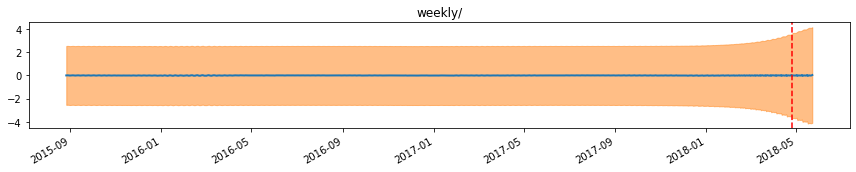

In [19]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
    
for k in temperature_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate([
        temperature_component_means_[k],
        temperature_forecast_component_means_[k]
    ], axis=-1)
    component_with_forecast_stddevs_[k] = np.concatenate([
        temperature_component_stddevs_[k],
        temperature_forecast_component_stddevs_[k]
    ], axis=-1)

fig, axes = plot_components(
    dates[-num_to_plot_for_decomp:],
    component_with_forecast_means_,
    component_with_forecast_stddevs_,
    vals_to_plot = plot_num
)
for ax in axes.values():
  ax.axvline(dates.to_numpy()[-num_forecast_steps], linestyle="--", color='red')
